In [47]:
!pip install pyro-ppl --upgrade

Requirement already up-to-date: pyro-ppl in /anaconda3/lib/python3.7/site-packages (1.0.0)


In [49]:
from __future__ import absolute_import, division, print_function

import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, accuracy_score

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, JitTrace_ELBO, TracePredictive
from pyro.infer.predictive import Predictive as pred
from pyro.contrib.autoguide import AutoMultivariateNormal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.util import diagnostics

import pyro.optim as optim
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
from pyro.ops.stats import waic
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from copy import deepcopy
from imblearn.under_sampling import RandomUnderSampler
import pickle
from mpl_toolkits.mplot3d import Axes3D


pyro.set_rng_seed(1)
# assert pyro.__version__.startswith('0.4.1')
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline
logging.basicConfig(format='%(message)s', level=logging.INFO)
# Enable validation checks
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

## Data

In [7]:
data = pd.read_csv('raw_data/Final_all_features_correct_data.csv')
data['target'] = data.apply(lambda row : row['FELONY'] + row['MISDEMEANOR'] + row['VIOLATION'], axis=1)
data['target'] = data['target'].astype(int)
data.to_csv("fin_data.csv")

In [8]:
data.head()

,Unnamed: 0,CensusTract,TotalPop,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,...,FamilyWork,Unemployment,restaurants,bar,park,subway_station,FELONY,MISDEMEANOR,VIOLATION,target
0,0,36005000200,5403.0,72034.0,13991.0,22180.0,2206.0,20.0,20.7,28.7,...,0.0,7.7,207.0,6.0,16.0,0.0,12,19,7,38
1,1,36005000400,5915.0,74836.0,8407.0,27700.0,2449.0,13.2,23.6,32.2,...,0.6,9.5,395.0,7.0,47.0,0.0,16,38,4,58
2,2,36005001600,5879.0,32312.0,6859.0,17526.0,2945.0,26.3,35.9,19.1,...,0.0,8.7,140.0,4.0,23.0,0.0,16,36,7,59
3,3,36005001900,2591.0,37936.0,3771.0,17986.0,2692.0,37.1,31.5,35.4,...,0.0,19.2,626.0,68.0,66.0,15.0,28,72,11,111
4,4,36005002000,8516.0,18086.0,3694.0,12023.0,2346.0,53.2,67.7,14.5,...,0.0,17.2,120.0,5.0,15.0,0.0,28,66,18,112


## Helper Functions

In [9]:
#Global variables
bool_split = 39
offset = 0
features = ['TotalPop', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment','restaurants', 'bar', 'park', 'subway_station']
target = 'binary_target'    

In [10]:
def get_data(data, features, target):
    df_X = data[features]
    df_y = data[target]
    rus = RandomUnderSampler(random_state=42)
    Xus, yus = rus.fit_resample(df_X, df_y)
    print(len(Xus),len(yus))
    X_train, X_test, y_train, y_test = train_test_split(Xus, yus, test_size=0.2)
    # Train Data
    X_np_train = normalize(np.array(X_train))
    y_np_train = np.array(y_train)
    X_nuts_train = torch.from_numpy(X_np_train).type(torch.float32)
    y_nuts_train = torch.from_numpy(y_np_train).type(torch.float32)
    #Test Data
    X_np_test = normalize(np.array(X_test))
    y_np_test = np.array(y_test)
    print(y_np_test.sum(), len(y_np_test)-y_np_test.sum())
    X_nuts_test = torch.from_numpy(X_np_test).type(torch.float32)
    y_nuts_test = torch.from_numpy(y_np_test).type(torch.float32)
    return X_nuts_train, y_nuts_train, X_nuts_test, y_nuts_test

In [11]:
def sep_data(row):
    if row['target'] >= bool_split + offset :
        return 1
    elif row['target'] <= bool_split - offset :
        return 0
    else:
        return float('nan')

In [12]:
def predict(x,model,guide, node1=None, node2=None):
    model_preds = []
    if not node1:
        for i in range(len(x)):
            guide_trace = pyro.poutine.trace(guide).get_trace(x,None,x.shape[1])
            replay_result = pyro.poutine.replay(model, guide_trace)(x,None,x.shape[1])
            model_preds.append(replay_result.detach().numpy())
    else:
        for i in range(len(x)):
            guide_trace = pyro.poutine.trace(guide).get_trace(x,None, node1, node2, x.shape[1])
            replay_result = pyro.poutine.replay(model, guide_trace)(x,None, node1, node2, x.shape[1])
            model_preds.append(replay_result.detach().numpy())
    preds = np.array(model_preds).mean(axis=0)
    y_pred = [i>=0.5 for i in preds]
    acc = accuracy_score(y_pred, y_nuts_test)
    return model_preds, y_pred, acc

## Get Test and Train dataset 

In [13]:
data_new = deepcopy(data)
data_new['binary_target'] = data_new.apply(sep_data, axis=1)
data_new = data_new.dropna()
X_nuts_train, y_nuts_train, X_nuts_test, y_nuts_test = get_data(data_new, features, target)

1812 1812
184 179


In [14]:
low_emb_test_2 = TSNE(n_components=2).fit_transform(X_nuts_test)
low_emb_train_2 = TSNE(n_components=2).fit_transform(X_nuts_train)
low_emb_test_3 = TSNE(n_components=3).fit_transform(X_nuts_test)
low_emb_train_3 = TSNE(n_components=3).fit_transform(X_nuts_train)

tnse_dict = {'2d': {'train':low_emb_train_2 , 'test':low_emb_test_2},
            '3d': {'train':low_emb_train_3 ,'test':low_emb_test_3}}

KeyboardInterrupt: 

## Vizualizer helpers

In [ ]:
def low_dim_2d(labels, n_comp=2):
    feature_vector = tnse_dict['2d']['test']
    color_map = { 0:'blue', 1:'red'}
    plt.scatter(feature_vector[:,0], feature_vector[:,1], c = [color_map[y] for y in labels])
    plt.show()
    
def low_dim_3d(labels, n_comp=3):
    feature_vector = tnse_dict['3d']['test']
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    color_map = { 0:'blue', 1:'red'}
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(feature_vector[:,0], feature_vector[:,1], feature_vector[:,2], c = [color_map[y] for y in labels])
    return fig

In [ ]:
f = low_dim_2d(y_nuts_test.numpy())

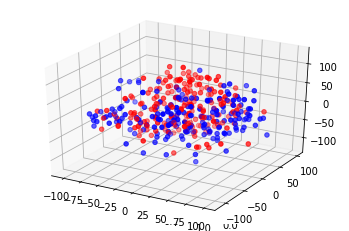

In [13]:
f = low_dim_3d(y_nuts_test.numpy())

## Logistic Regression Baseline

In [13]:
print(bool_split, offset)
reg = LogisticRegression(C=0.8).fit(X_nuts_train, y_nuts_train)
print('Train Score : ',reg.score(X_nuts_train, y_nuts_train))
print('Test Score :', reg.score(X_nuts_test, y_nuts_test))
print('-'*30)

39 0
Train Score :  0.7349896480331263
Test Score : 0.7079889807162535
------------------------------


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


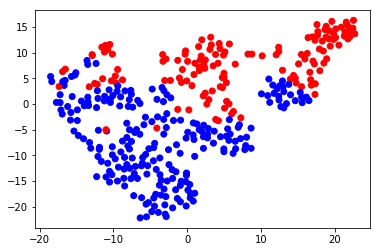

In [14]:
k = low_dim_2d(reg.predict(X_nuts_test))

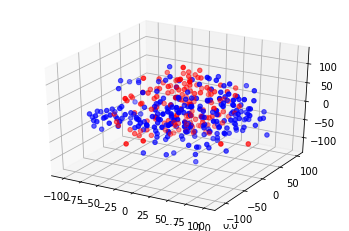

In [15]:
k = low_dim_3d(reg.predict(X_nuts_test))

## Bayesian  Baseline

In [15]:
def model_1(data_x, data_y, D):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(torch.tensor(0.), torch.tensor(10.))))
    
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    
    p = torch.tensor(1.) / (torch.tensor(1.) + torch.exp(-logit))

    with pyro.plate("data", len(data_x)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    
    return p 


def guide_1(data_x, data_y, D):
    
    mu_i = []
    sigma_i = []
    for i in range(D+1):
        mu_i.append(pyro.param('mu_i'+str(i),torch.tensor(0.),constraint = constraints.real))
        sigma_i.append(pyro.param('sigma_i'+str(i),torch.tensor(10.), constraint = constraints.positive))
    
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(mu_i[i], sigma_i[i])))
        

    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]

    
    p = 1. / (1 + torch.exp(-logit))

In [16]:
svi = SVI(model_1, 
          guide_1, 
          optim.Adam({"lr": 5e-3}), 
          loss=JitTrace_ELBO(), 
          num_samples=2000)

pyro.clear_param_store()
elbo_arr_1 = []
for i in range(50):
    elbo = svi.step(X_nuts_train, y_nuts_train, torch.tensor(X_nuts_train.shape[1]).type(torch.long))
    elbo_arr_1.append(elbo)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 11339.6396484375


In [54]:
res = pred(model=model_1, guide=guide_1, num_samples=1).forward(X_nuts_train, None, torch.tensor(X_nuts_train.shape[1]).type(torch.long))
res['obs'].shape

torch.Size([1, 1449])

In [32]:
posterior = svi.run(X_nuts_train, None, torch.tensor(X_nuts_train.shape[1]).type(torch.long))

In [33]:
p = TracePredictive(model_1, posterior, 5).run(X_nuts_train, None, torch.tensor(X_nuts_train.shape[1]).type(torch.long))

In [34]:
posterior_sample = p(X_nuts_train, None, torch.tensor(X_nuts_train.shape[1]).type(torch.long))

In [38]:
posterior_samples = p.marginal().empirical['_RETURN']._samples


In [40]:
posterior_samples.shape

torch.Size([5, 1449])

In [36]:
p.marginals(['beta0']).empirical['beta0']


AttributeError: 'TracePredictive' object has no attribute 'marginals'

In [27]:
posterior_sample.param_nodes

[]

In [25]:
from collections import defaultdict
params = defaultdict(list)
# for i in range(num_samples):
#     guide_trace = pyro.poutine.trace(guide).get_trace(x,None,node1,node2,D,month_test)
for name in posterior_sample.param_nodes:
    params[name].append(posterior_sample.nodes[name]["value"].unconstrained())
# for k,v in params.items():
#     params_means[k] = torch.mean(torch.tensor(v))

In [26]:
params

defaultdict(list, {})

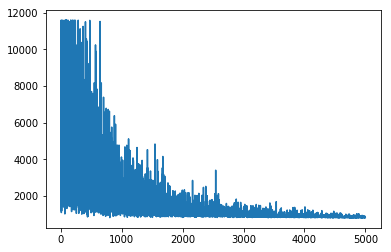

In [18]:
plt.plot(elbo_arr_1)

In [19]:
model_preds, y_pred, acc = predict(X_nuts_test, model_1, guide_1)

In [20]:
acc

0.7079889807162535

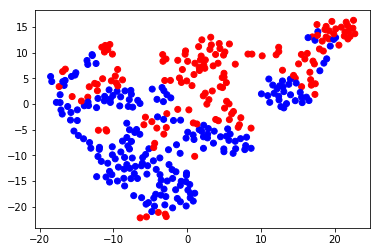

In [21]:
k = low_dim_2d(y_pred)

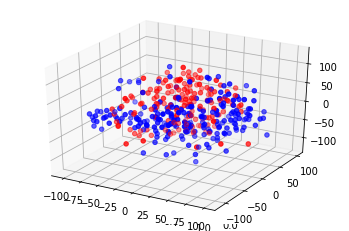

In [22]:
k = low_dim_3d(y_pred)

# Model 2 : Adding noise to add randomness to spatial data 

In [23]:
usi_alpha = 0.1
usi_beta = 0.1

def model_2(data_x, data_y, D):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 1.)))   
    sd_u = pyro.sample("sd_u",dist.Gamma(usi_alpha,usi_beta))
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0., sigma2_ui))
    logit += u_i
    p = 1. / (1 + torch.exp(-logit))
    with pyro.plate("data", len(data_x)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
    return p


def guide_2(data_x, data_y, D):
    mu_i = []
    sigma_i = []
    for i in range(D+1):
        mu_i.append(pyro.param('mu_i'+str(i),torch.tensor(0.),constraint = constraints.real))
        sigma_i.append(pyro.param('sigma_i'+str(i),torch.tensor(1.), constraint = constraints.positive))
    beta = []
    for i in range(D+1):
#         print(mu_i[i],sigma_i[i])
        beta.append(pyro.sample("beta"+str(i), dist.Normal(mu_i[i], sigma_i[i])))     
    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    alpha_gamma = pyro.param('alpha_gamma',torch.tensor(usi_alpha).type(torch.float32),constraint = constraints.positive)
    beta_gamma = pyro.param('beta_gamma',torch.tensor(usi_beta).type(torch.float32),constraint = constraints.positive)
    sd_u = min(pyro.sample("sd_u",dist.Gamma(alpha_gamma, beta_gamma)),500)
    sigma2_ui = 1/((sd_u+1)**2) 
#     print('sigma : ',sigma2_ui)
    u_i = pyro.sample("u_i",dist.Normal(0., sigma2_ui))

    logit += u_i
    
    p = 1. / (1 + torch.exp(-logit))
    
    return p


In [24]:
pyro.clear_param_store()
svi = SVI(model_2, 
          guide_2, 
          optim.Adam({"lr": 5e-3}), 
          loss=JitTrace_ELBO(), 
          num_samples=20000)

pyro.clear_param_store()
elbo_arr_2 = []
for i in range(10000):
    elbo = svi.step(X_nuts_train, y_nuts_train, torch.tensor(X_nuts_train.shape[1]).type(torch.long))
    elbo_arr_2.append(elbo)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function.

Elbo loss: 2000.4422607421875
Elbo loss: 863.5447998046875
Elbo loss: 885.5249633789062
Elbo loss: 859.8388061523438
Elbo loss: 858.6223754882812
Elbo loss: 864.8198852539062
Elbo loss: 883.7538452148438
Elbo loss: 859.0703125
Elbo loss: 858.9366455078125
Elbo loss: 874.818359375


In [ ]:
plt.plot(elbo_arr_2)

In [26]:
model_preds_2, y_pred_2, acc_2 = predict(X_nuts_test, model_2, guide_2)

In [27]:
acc_2

0.7134986225895317

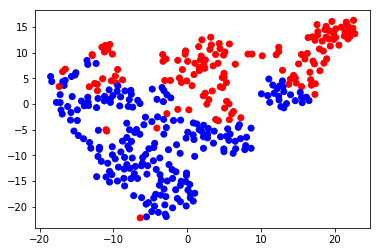

In [28]:
k = low_dim_2d(y_pred_2)

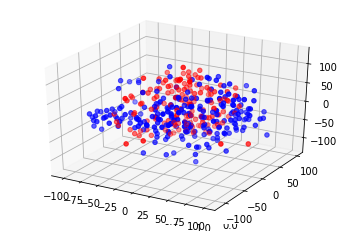

In [29]:
k = low_dim_3d(y_pred_2)

## ICAR Model

In [30]:
W = pickle.load(open("weight_matrix","rb"))

In [31]:
node1 = []
node2 = []

for i in range(len(W)):
    for j in range(i+1,len(W)):
        if W[i][j]==1:
            node1.append(i)
            node2.append(j)

In [14]:
si_alpha = 0.5
si_beta = 0.5

usi_alpha = 0.3
usi_beta = 0.1

def model_icar(data_x, data_y, node1, node2,D):
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(0., 1.0)))
    
    logit = beta[0]
    for i in range(data_x.shape[1]):
        logit = logit + beta[i+1]*data_x[:,i]
    
    #unstructured random noise
    sd_u = pyro.sample("sd_u",dist.Gamma(usi_alpha, usi_beta))
    sigma2_ui = 1/(sd_u**2) 
    u_i = pyro.sample("u_i",dist.Normal(0, sigma2_ui))
    logit += u_i
    
    #structured random noise
    sd_s = pyro.sample("sd_s",dist.Gamma(si_alpha, si_beta))
    sigma2_si = 1/(sd_s**2) 
    
    sum_p = 0
    phi = []
    for i in range(2078):
        p = pyro.sample("phi"+str(i), dist.Normal(0.,1.))
        phi.append(p)
        sum_p += p
    phi.append(-sum_p)

    phi = torch.from_numpy(np.array(phi, dtype='float32')).type(torch.float32)
    diff = phi[node1] - phi[node2]
    phi_joint = torch.exp(-0.5 * torch.dot(diff,diff)) 
    
    logit = phi_joint*sigma2_si
        
        
    p = 1. / (1 + torch.exp(-logit)) 


    with pyro.plate("data", len(data_x)):
        y = pyro.sample("obs",dist.Bernoulli(p), obs=data_y)
        
    return p
        
def guide_icar(data_x, data_y, node1, node2,D):
    mu_i = []
    sigma_i = []
    for i in range(D+1):
        mu_i.append(pyro.param('mu_i'+str(i),torch.tensor(0.),constraint = constraints.real))
        sigma_i.append(pyro.param('sigma_i'+str(i),torch.tensor(1.), constraint = constraints.positive))
    
    beta = []
    for i in range(D+1):
        beta.append(pyro.sample("beta"+str(i), dist.Normal(mu_i[i], sigma_i[i])))     

    logit = beta[0]
    for i in range(D):
        logit = logit + beta[i+1]*data_x[:,i]
    
    alpha_gamma = pyro.param('alpha_gamma',torch.tensor(usi_alpha).type(torch.float32),constraint = constraints.positive)
    beta_gamma = pyro.param('beta_gamma',torch.tensor(usi_beta).type(torch.float32),constraint = constraints.positive)
      
    sd_u = pyro.sample("sd_u",dist.Gamma(alpha_gamma, beta_gamma))
    sigma2_ui = 1/((sd_u+1)**2) 
    u_i = pyro.sample("u_i",dist.Normal(0., sigma2_ui))
    
    
    alpha_si = pyro.param('alpha_si',torch.tensor(si_alpha).type(torch.float32),constraint = constraints.positive)
    beta_si = pyro.param('beta_si',torch.tensor(si_beta).type(torch.float32),constraint = constraints.positive)
      
    sd_s = pyro.sample("sd_s",dist.Gamma(alpha_si,beta_si))
    sigma2_si = 1/(sd_s**2) 
    
    phi = []
    sum_p = 0
    for i in range(2078):
        p = pyro.sample("phi"+str(i), dist.Normal(0.,1.))
        phi.append(p)
        sum_p += p
    phi.append(-sum_p)
    
    phi = torch.from_numpy(np.array(phi, dtype='float32')).type(torch.float32)
    diff = phi[node1] - phi[node2]
    
    phi_joint = torch.exp(-0.5 * torch.dot(diff,diff)) 
    
    logit = phi_joint*sigma2_si
    
    
#     logit += u_i
    
    p = 1. / (1 + torch.exp(-logit))
    
    return p


In [25]:
elbo_arr_icar = []

pyro.clear_param_store()
svi = SVI(model_icar, 
          guide_icar, 
          optim.Adam({"lr": 5e-3}), 
          loss=JitTrace_ELBO(), 
          num_samples=1000)

pyro.clear_param_store()
D = torch.tensor(X_nuts_train.numpy().shape[1]).type(torch.long)
for i in range(7000):
    elbo = svi.step(X_nuts_train, y_nuts_train, torch.from_numpy(np.array(node1)).type(torch.long), torch.from_numpy(np.array(node2)).type(torch.long),D)
    elbo_arr_icar.append(elbo)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

NameError: name 'node1' is not defined

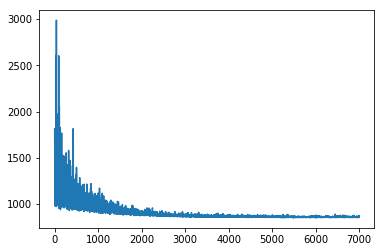

In [63]:
plt.plot(elbo_arr_icar)

In [64]:
model_preds_3, y_pred_3, acc_3 = predict(X_nuts_test, model_icar, guide_icar, node1, node2)

In [65]:
acc_3

0.7024793388429752

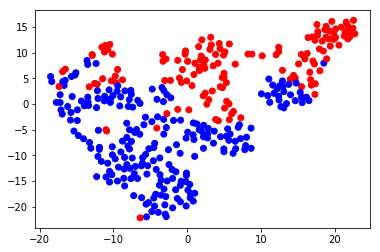

In [66]:
k = low_dim_2d(y_pred_3)

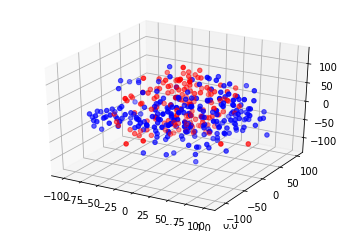

In [67]:
k = low_dim_3d(y_pred_3)

## ICAR Model with 2 hops

In [15]:
W_h2 = pickle.load(open("weight_matrix_hops_2","rb"))

In [16]:
node1_h2 = []
node2_h2 = []

for i in range(len(W_h2)):
    for j in range(i+1,len(W_h2)):
        if W_h2[i][j]==1:
            node1_h2.append(i)
            node2_h2.append(j)

In [17]:
elbo_arr_icar_2 = []

pyro.clear_param_store()
svi = SVI(model_icar, 
          guide_icar, 
          optim.Adam({"lr": 5e-3}), 
          loss=JitTrace_ELBO(), 
          num_samples=1000)

pyro.clear_param_store()
D = torch.tensor(X_nuts_train.numpy().shape[1]).type(torch.long)
for i in range(7000):
    elbo = svi.step(X_nuts_train, y_nuts_train, torch.from_numpy(np.array(node1_h2)).type(torch.long), torch.from_numpy(np.array(node2_h2)).type(torch.long),D)
    elbo_arr_icar_2.append(elbo)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 1017.441650390625
Elbo loss: 1005.2901611328125
Elbo loss: 1005.7713623046875
Elbo loss: 1004.941650390625
Elbo loss: 1005.67822265625
Elbo loss: 1005.0806274414062
Elbo loss: 1005.1095581054688
Elbo loss: 1006.7105102539062
Elbo loss: 1005.8585815429688
Elbo loss: 1005.2998046875
Elbo loss: 1005.5591430664062
Elbo loss: 1005.6510620117188
Elbo loss: 1005.7032470703125
Elbo loss: 1005.7703247070312


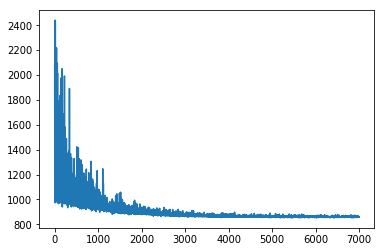

In [19]:
plt.plot(elbo_arr_icar_2)


In [21]:
model_preds_5, y_pred_5, acc_5 = predict(X_nuts_test, model_icar, guide_icar, node1_h2, node2_h2)


In [22]:
acc_5

0.7024793388429752

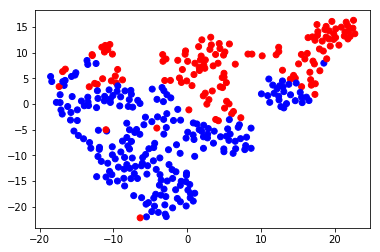

In [23]:
k = low_dim_2d(y_pred_5)

NameError: name 'elbo_arr_icar' is not defined